## Install dependencies


In [1]:
!pip install haystack-ai cohere-haystack ragas-haystack

## Import Libraries


In [70]:
import os
from getpass import getpass
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path

from datasets import load_dataset
from datasets import load_from_disk
from haystack import Document
from haystack import Pipeline
from haystack.document_stores.types import DuplicatePolicy
from haystack.document_stores.in_memory import InMemoryDocumentStore
from haystack_integrations.components.embedders.cohere.text_embedder import (
    CohereTextEmbedder,
)
from haystack_integrations.components.embedders.cohere.document_embedder import (
    CohereDocumentEmbedder,
)
from haystack.components.retrievers.in_memory import InMemoryEmbeddingRetriever
from haystack.components.builders.prompt_builder import PromptBuilder
from haystack_integrations.components.generators.cohere import CohereGenerator
from haystack_integrations.components.evaluators.ragas import (
    RagasEvaluator,
    RagasMetric,
)

## Load Dataset

- CSV containing the QA of the legal dataset obtained from [Multi Eurlex](https://huggingface.co/papers/2109.00904) dataset


In [3]:
data_path = Path("./data-consolidated.csv")
# if data_path.exists():
#     data_path.unlink()
#     print("Existing file deleted successfully.")

In [4]:
!wget https://gist.githubusercontent.com/srini047/4e66d35c742a5f1126d7819bad3a17b1/raw/750224f512af8704266b2205a8517c038ac8be9c/data-consolidated.csv

/bin/bash: wget: command not found


## Set Environment Variables

- `COHERE_API_KEY`: Get from https://dashboard.cohere.com/api-keys


In [5]:
os.environ["COHERE_API_KEY"] = getpass("Enter Cohere API key: ")

In [39]:
os.environ["OPENAI_API_KEY"] = getpass("Enter OpenAI API key: ")

## Initialize Document Store

- `Type`: In Memory
- `Search`: Cosine Similarity
- `Document`: Contains the data
  -- `content`: Question and Answer
  -- `meta`: Optional[None]


In [6]:
document_store = InMemoryDocumentStore(embedding_similarity_function="cosine")

In [7]:
with open(data_path, "r") as file:
    # data = json.load(file)
    data = pd.read_csv(file, sep=",")

In [8]:
data.rename(columns={"answer-command-r": "answer"})

,question,language_code,answer
0,Frage: Welche Bauprodukte müssen nicht auf ihr...,de,"\n\nAntwort: Eine Prüfung ist für Produkte, di..."
1,Frage: Welche Verordnung legt die pauschalen E...,de,\n\nAntwort: Die Verordnung (EG) Nr. 1330/2003...
2,Frage: Welche Menge an künstlich getrocknetem ...,de,\n\nAntwort: Für die Zahlung der Beihilfe darf...
3,Frage: Was ist die Rechtsgrundlage für die Änd...,de,\n\nAntwort: Die Rechtsgrundlage bildet der Ve...
4,Frage: Welche Dumpingspanne wurde für Waren mi...,de,"\n\nAntwort: Für Unternehmen, die nicht an der..."
...,...,...,...
2495,What are the requirements for producers to ben...,en,\n\nProducers must fulfill the obligations lai...
2496,Q: Which region is no longer part of the list ...,en,\nA: Rheinhessen-Pfalz.
2497,Q: What is the purpose of Commission Regulatio...,en,\nA: Commission Regulation (EC) No. 110/97 est...
2498,Question: What is the buying-in price of wine ...,en,\n\nAnswer: The buying-in prices of wine deliv...


In [9]:
documents = []
for index, doc in data.iterrows():
    if isinstance(doc["answer"], str) and len(doc["answer"]):
        ques = doc["question"].encode().decode()
        ans = doc["answer"].encode().decode()

        documents.append(Document(content="Question: " + ques + "\nAnswer: " + ans))

## Flow

Document(s) => Embedder => Document Store => Retriever => Prompt Builder => Generator => Response


In [10]:
document_embedder = CohereDocumentEmbedder(model="embed-multilingual-v2.0")

In [11]:
documents_with_embeddings = document_embedder.run(documents=documents)["documents"]

Calculating embeddings: 100%|██████████| 77/77 [02:13<00:00,  1.73s/it]


In [12]:
len = document_store.write_documents(
    documents_with_embeddings, policy=DuplicatePolicy.SKIP
)

print(f"{len} documents added to the document store.")

ID 'e2c01bd1bd34e3838a19784b6f25aea2f5645e2d834374ff2e44e35010eae7df' already exists
ID '8df63116e690a655a0212ad803965b62006c797a4fc67850549d1bf97a6ed5fc' already exists


2448 documents added to the document store.


In [13]:
template = """
Given the following information, answer the question.

Context:
{% for document in documents %}
    {{ document.content }}
{% endfor %}

Question: {{ query }}?
"""

In [14]:
query_pipeline = Pipeline()
query_pipeline.add_component(
    "text_embedder", CohereTextEmbedder(model="embed-multilingual-v2.0")
)
query_pipeline.add_component(
    "retriever", InMemoryEmbeddingRetriever(document_store=document_store)
)
query_pipeline.add_component("prompt_builder", PromptBuilder(template=template))
query_pipeline.add_component("llm", CohereGenerator())
query_pipeline.connect("text_embedder.embedding", "retriever.query_embedding")
query_pipeline.connect("retriever", "prompt_builder.documents")
query_pipeline.connect("prompt_builder", "llm")

🚅 Components
  - text_embedder: CohereTextEmbedder
  - retriever: InMemoryEmbeddingRetriever
  - prompt_builder: PromptBuilder
  - llm: CohereGenerator
🛤️ Connections
  - text_embedder.embedding -> retriever.query_embedding (List[float])
  - retriever.documents -> prompt_builder.documents (List[Document])
  - prompt_builder.prompt -> llm.prompt (str)

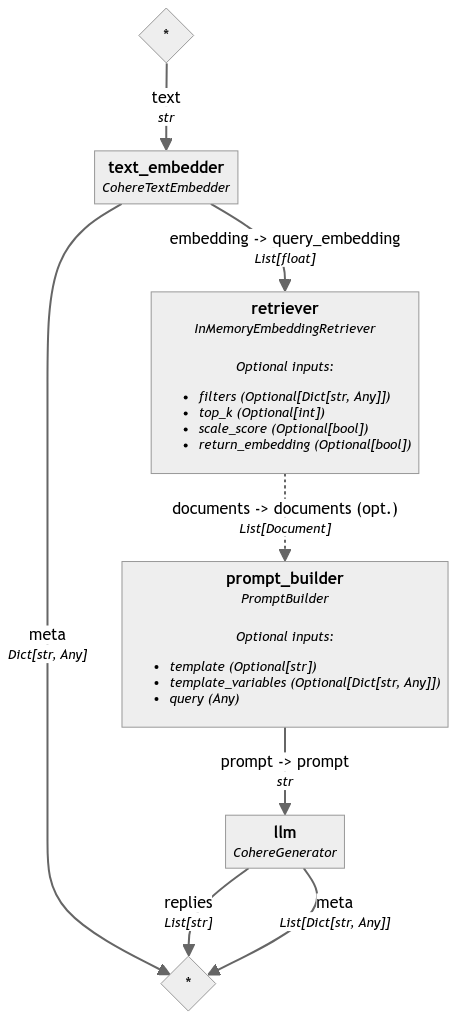

In [15]:
query_pipeline.show()

In [16]:
query = "According to the provided legal document, what was the overarching purpose of the European Commission Decision 2006/213/CE?"

result = query_pipeline.run({"text_embedder": {"text": query}})

In [17]:
result["llm"]["replies"][0]

'The main purpose of this Commission Decision is to adopt a preparatory action to enhance the European industrial potential in the field of security research. This aims to contribute to the advancement of European security through research and technology.'

## Evaluation - [Ragas](https://docs.ragas.io/en/stable/concepts/metrics/index.html)


In [18]:
def generate_responses_evaluate(questions):
    responses = []
    for q in questions:
        query = q
        result = query_pipeline.run({"text_embedder": {"text": query}})
        responses.append(result["llm"]["replies"][0])

    return responses

In [37]:
questions = [
    "Welcher Betrag wurde als Höchstgrenze für die Erstattung bei der Ausfuhr von Weißzucker im Rahmen der 28. Teilausschreibung gemäß der Verordnung (EG) Nr. 1290/2003 festgelegt?",
    "Ab wann wird der Zollsatz für Einfuhren von Bettwäsche mit Ursprung in Malaysia wiedereingeführt und welche Waren sind betroffen?",
    "Quel est le montant du plafond individuel pour les produits du code NC 9105 originaires de Chine qui bénéficient de préférences tarifaires en vertu du règlement (CEE) n° 3831/90?",
    "Quelle est la date jusqu'à laquelle s'applique la décision de la Commission modifiant la décision 2008/866/CE en ce qui concerne sa durée d'application?",
    "Cuándo entró en vigor el Reglamento (CE) n.º 3549/93?",
    "Cuál es el objetivo del Reglamento de la Comisión (CE) n ° 2007/2003",
    "Qual é o objetivo do Regulamento (CE) n.o 1906/2005 da Comissão?",
    "Qual é o montante máximo de ajuda financeira que a Comunidade concede aos Países Baixos para o funcionamento do seu laboratório de referência no domínio das incidências veterinárias (resíduos) na saúde pública, no período de 1 de Julho a 31 de Dezembro de 2002?",
    "What is the purpose of Commission Regulation (EC) No 1065/2002?",
    "What is the total volume of the Community tariff quota, after the amendments made by this Regulation, for ferro-chromium containing not less than 6% by weight of carbon, falling within subheading ex 73.02 E I of the Common Customs Tariff?",
]

contexts = [
    ["49,950 EUR pro 100 kg."],
    [
        "Ab dem 2. November 1992 wird der Zollsatz für Einfuhren von Bettwäsche mit Ursprung in Malaysia wiedereingeführt. Die Maßnahme betrifft Waren der Kategorie 20 (laufende Nummer 40.0200), darunter Bettwäsche aus Gewirken und andere Bettwäsche, die unter die KN-Codes fallen: 6302 21 00, 6302 22 90, 6302 29 90, 6302 31 10, 6302 31 90, 6302 32 90 und 6302 39 90."
    ],
    [
        "Le plafond individuel pour les produits du code NC 9105 originaires de Chine s'établit à 5 182 000 écus."
    ],
    ["La décision est valable jusqu'au 30 novembre 2010."],
    ["El Reglamento (CE) n.º 3549/93 entró en vigor el 1 de enero de 1994."],
    [
        "El Reglamento de la Comisión (CE) n ° 2007/2003 establece los importes máximos de la ayuda para la nata, la mantequilla y la mantequilla concentrada en la 130a licitación específica bajo el marco de la licitación permanente contemplada en el Reglamento (CE) n ° 2571/97 del Consejo. Este último reglamento se refiere a la venta a precio reducido de mantequilla de intervención y a la concesión de ayudas para la nata, mantequilla y mantequilla concentrada destinadas a ciertos fines alimentarios. El Reglamento (CE) n ° 2007/2003 fija estos importes máximos de ayuda y garantías de transformación teniendo en cuenta las ofertas recibidas en la licitación específica, y entran en vigor el 15 de noviembre de 2003."
    ],
    [
        "O objetivo do Regulamento (CE) n.o 1906/2005 é estabelecer os valores forfetários de importação para a determinação do preço de entrada de certos frutos e produtos hortícolas da UE. Estes valores são usados no regime de importação dos frutos e produtos hortícolas frescos para a União Europeia e são aplicados a partir de 23 de Novembro de 2005."
    ],
    ["O montante máximo é de 200 000 euros."],
    [
        "The purpose of this Regulation is to amend the corrective amount applicable to the refund on cereals, in accordance with the common organisation of the market in cereals established by Council Regulation (EEC) No 1766/92. This corrective amount adjustment is based on today's cif prices and cif forward delivery prices, taking foreseeable market developments into account."
    ],
    ["The total volume is 374,000 tonnes."],
]

In [20]:
responses = generate_responses_evaluate(questions)

In [43]:
# Evaluating using the Generation metrics from Ragas
evaluator_faithfulness = RagasEvaluator(metric=RagasMetric.FAITHFULNESS)
evaluator_answer_relevancy = RagasEvaluator(
    metric=RagasMetric.ANSWER_RELEVANCY, metric_params={"strictness": 2}
)
evaluator_aspect_critique = RagasEvaluator(
    metric=RagasMetric.ASPECT_CRITIQUE,
    metric_params={
        "name": "conciseness",
        "definition": "Is the generation short but contextual based on the question asked?",
        "strictness": 2,
    },
)

### Evaluator Pipeline


In [44]:
evaluator_pipeline = Pipeline()

In [45]:
evaluator_pipeline.add_component("evaluator_faithfulness", evaluator_faithfulness)
evaluator_pipeline.add_component(
    "evaluator_answer_relevancy", evaluator_answer_relevancy
)
evaluator_pipeline.add_component("evaluator_aspect_critique", evaluator_aspect_critique)

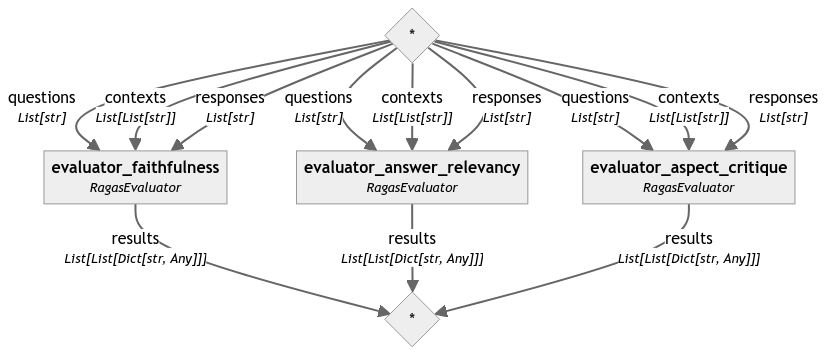

In [84]:
evaluator_pipeline.show()

In [46]:
results = evaluator_pipeline.run(
    {
        "evaluator_faithfulness": {
            "questions": questions,
            "contexts": contexts,
            "responses": responses,
        },
        "evaluator_answer_relevancy": {
            "questions": questions,
            "contexts": contexts,
            "responses": responses,
        },
        "evaluator_aspect_critique": {
            "questions": questions,
            "contexts": contexts,
            "responses": responses,
        },
    }
)

Evaluating: 100%|██████████| 10/10 [00:02<00:00,  4.03it/s]


In [47]:
results

{'evaluator_faithfulness': {'results': [[{'name': 'faithfulness',
     'score': 0.0}],
   [{'name': 'faithfulness', 'score': 1.0}],
   [{'name': 'faithfulness', 'score': 0.0}],
   [{'name': 'faithfulness', 'score': 0.0}],
   [{'name': 'faithfulness', 'score': 0.0}],
   [{'name': 'faithfulness', 'score': 0.0}],
   [{'name': 'faithfulness', 'score': 0.0}],
   [{'name': 'faithfulness', 'score': 0.0}],
   [{'name': 'faithfulness', 'score': 0.0}],
   [{'name': 'faithfulness', 'score': 0.0}]]},
 'evaluator_answer_relevancy': {'results': [[{'name': 'answer_relevancy',
     'score': 0.8589221850417496}],
   [{'name': 'answer_relevancy', 'score': 0.8912783127739099}],
   [{'name': 'answer_relevancy', 'score': 0.9033304173996533}],
   [{'name': 'answer_relevancy', 'score': 0.8938339892056123}],
   [{'name': 'answer_relevancy', 'score': 0.8413605955118748}],
   [{'name': 'answer_relevancy', 'score': 0.7965132307191779}],
   [{'name': 'answer_relevancy', 'score': 0.8146683608420976}],
   [{'name':

In [81]:
results_values = []

for key in results.keys():
    temp = []
    for val in results[key]["results"]:
        temp.append(val[0]["score"])
    results_values.append(temp)

In [82]:
results_values

[[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [0.8589221850417496,
  0.8912783127739099,
  0.9033304173996533,
  0.8938339892056123,
  0.8413605955118748,
  0.7965132307191779,
  0.8146683608420976,
  0.8290060274874916,
  0.8882440460754001,
  0.8036314003717471],
 [0, 1, 0, 1, 0, 0, 0, 0, 0, 0]]

### Evaluator - [Answer Relevancy](https://docs.ragas.io/en/latest/concepts/metrics/answer_relevance.html)


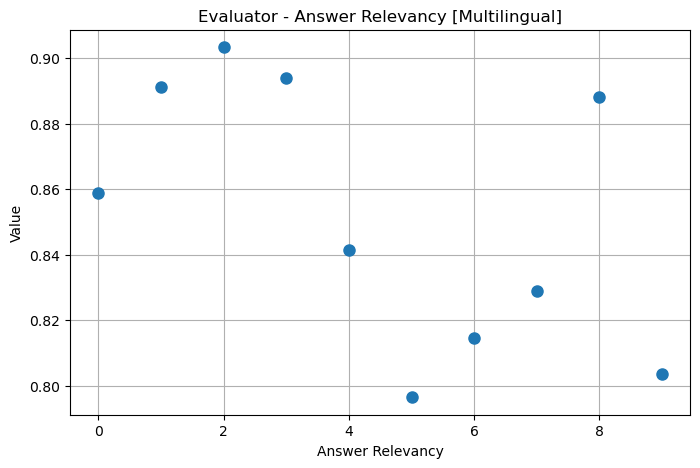

In [93]:
plt.figure(figsize=(8, 5))
plt.plot(results_values[1], "o", markersize=8)
plt.title("Evaluator - Answer Relevancy [Multilingual]")
plt.xlabel("Answer Relevancy")
plt.ylabel("Value")
plt.grid(True)
plt.show()

### Evaluator - [Faithfulness](https://docs.ragas.io/en/latest/concepts/metrics/faithfulness.html)

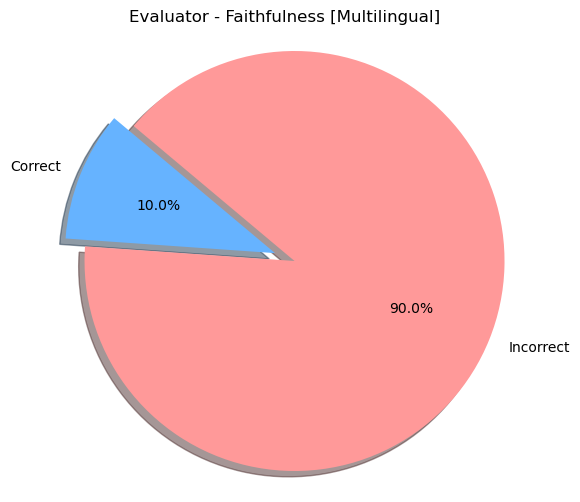

In [95]:
labels = ["Correct", "Incorrect"]
sizes = [results_values[0].count(1.0), results_values[0].count(0.0)]
colors = ["#66b3ff", "#ff9999"]
explode = (0.1, 0)

plt.figure(figsize=(6, 6))
plt.pie(
    sizes,
    explode=explode,
    labels=labels,
    colors=colors,
    autopct="%1.1f%%",
    shadow=True,
    startangle=140,
)

plt.axis("equal")
plt.title("Evaluator - Faithfulness [Multilingual]")
plt.show()

### Evaluator - [Aspect Critique](https://docs.ragas.io/en/latest/concepts/metrics/critique.html")

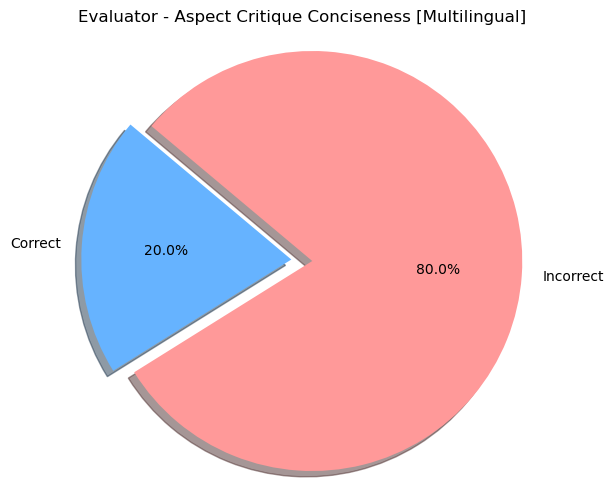

In [96]:
labels = ["Correct", "Incorrect"]
sizes = [results_values[2].count(1.0), results_values[2].count(0.0)]
colors = ["#66b3ff", "#ff9999"]
explode = (0.1, 0)

plt.figure(figsize=(6, 6))
plt.pie(
    sizes,
    explode=explode,
    labels=labels,
    colors=colors,
    autopct="%1.1f%%",
    shadow=True,
    startangle=140,
)

plt.axis("equal")
plt.title("Evaluator - Aspect Critique Conciseness [Multilingual]")
plt.show()